Generate Figures 1 and 2.

In [1]:
import vcm
import fsspec
import numpy as np
import xarray as xr
import os
import yaml
import matplotlib.pyplot as plt
from dask.distributed import Client
from vcm.catalog import catalog
from scipy.interpolate import interp1d

plt.rcParams['figure.dpi'] = 200
xr.set_options(keep_attrs=True)

In [2]:
Client()

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==2.2.3.
Continuing without the dashboard.
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35355,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:41797,Total threads: 2
Dashboard: http://127.0.0.1:43463/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:45869,


In [3]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)
url = runs['prescribed-physics-35day']['url']

In [4]:
DT_NUDGE = 3600 * 3  # nudging timescale in these runs

In [5]:
with open('ak.txt') as f:
    ak = list(map(float, f))
with open('bk.txt') as f:
    bk = list(map(float, f))
    
# reference pressure levels in hPa assuming 1000hPa surface pressure
plev = np.array(ak)/100 + np.array(bk) * 1000  
plev_mid = 0.5 * (plev[:-1] + plev[1:])

f = interp1d(plev_mid, range(0, 79), fill_value='extrapolate')
tick_labels = [3, 100, 300, 500, 700, 850, 1000]
tick_indices = f(tick_labels)

In [6]:
plev_mid[30]

269.056555361748

In [7]:
names_hourly = ['nudging_tendencies.zarr', 'physics_tendencies.zarr', 'state_after_timestep.zarr']

In [8]:
grid = catalog['grid/c48'].to_dask().load()

In [9]:
def open_3d(url):
    ds = []
    for name in names_hourly:
        tmp = xr.open_zarr(fsspec.get_mapper(os.path.join(url, name)))
        ds.append(tmp)
    ds = xr.merge(ds)
    
    for variable in ['air_temperature', 'specific_humidity']:
        ds[f'reference_{variable}'] = ds[variable] + DT_NUDGE * ds[f'{variable}_tendency_due_to_nudging']

    variable = 'air_temperature'
    for tendency in [f'tendency_of_{variable}_due_to_applied_physics', f'tendency_of_{variable}_due_to_dynamics', f'{variable}_tendency_due_to_nudging']:
        ds[tendency] = (86400 * ds[tendency]).assign_attrs(units='K/day')

    variable = 'specific_humidity'
    for tendency in [f'tendency_of_{variable}_due_to_applied_physics', f'tendency_of_{variable}_due_to_dynamics', f'{variable}_tendency_due_to_nudging']:
        ds[tendency] = (86400 * 1000 * ds[tendency]).assign_attrs(units='g/kg/day')
    return ds

In [10]:
ds = open_3d(url)

In [11]:
ds_time_mean = ds.mean('time').drop('latitude')

In [12]:
for variable in ['air_temperature', 'specific_humidity']:
    for tendency in [f'tendency_of_{variable}_due_to_applied_physics', f'tendency_of_{variable}_due_to_dynamics', f'{variable}_tendency_due_to_nudging']:
        ds_time_mean[f'{tendency}_zonal_mean'] = vcm.zonal_average_approximate(grid.lat, ds_time_mean[tendency], weights=grid.area, lat_name='latitude').compute()

In [13]:
for variable in ['air_temperature', 'specific_humidity']:
    for tendency in [f'tendency_of_{variable}_due_to_applied_physics', f'tendency_of_{variable}_due_to_dynamics', f'{variable}_tendency_due_to_nudging']:
        ds_time_mean[f'{tendency}_zonal_mean'] = ds_time_mean[f'{tendency}_zonal_mean'].assign_attrs(long_name=tendency.replace('_', ' '))

In [14]:
for variable in ['air_temperature', 'specific_humidity']:
    name = f'tendency_of_{variable}_due_to_applied_physics_plus_nudging_zonal_mean'
    ds_time_mean[name] = (
        ds_time_mean[f'tendency_of_{variable}_due_to_applied_physics_zonal_mean'] +
        ds_time_mean[f'{variable}_tendency_due_to_nudging_zonal_mean']
    ).assign_attrs(long_name=name.replace('_', ' '))

In [15]:
KWARGS = {'air_temperature': dict(vmin=-6, vmax=6, cmap='RdBu_r'), 'specific_humidity': dict(vmin=-2, vmax=2, cmap='RdBu_r')}
KWARGS_COMBINED = {'air_temperature': dict(vmin=-5, vmax=5, cmap='RdBu_r'), 'specific_humidity': dict(vmin=-1.5, vmax=1.5, cmap='RdBu_r')}
SMALL_KWARGS = {'air_temperature': dict(vmin=-3, vmax=3, cmap='RdBu_r'), 'specific_humidity': dict(vmin=-1, vmax=1, cmap='RdBu_r')}

### Plot zonal mean climatologies of tendencies

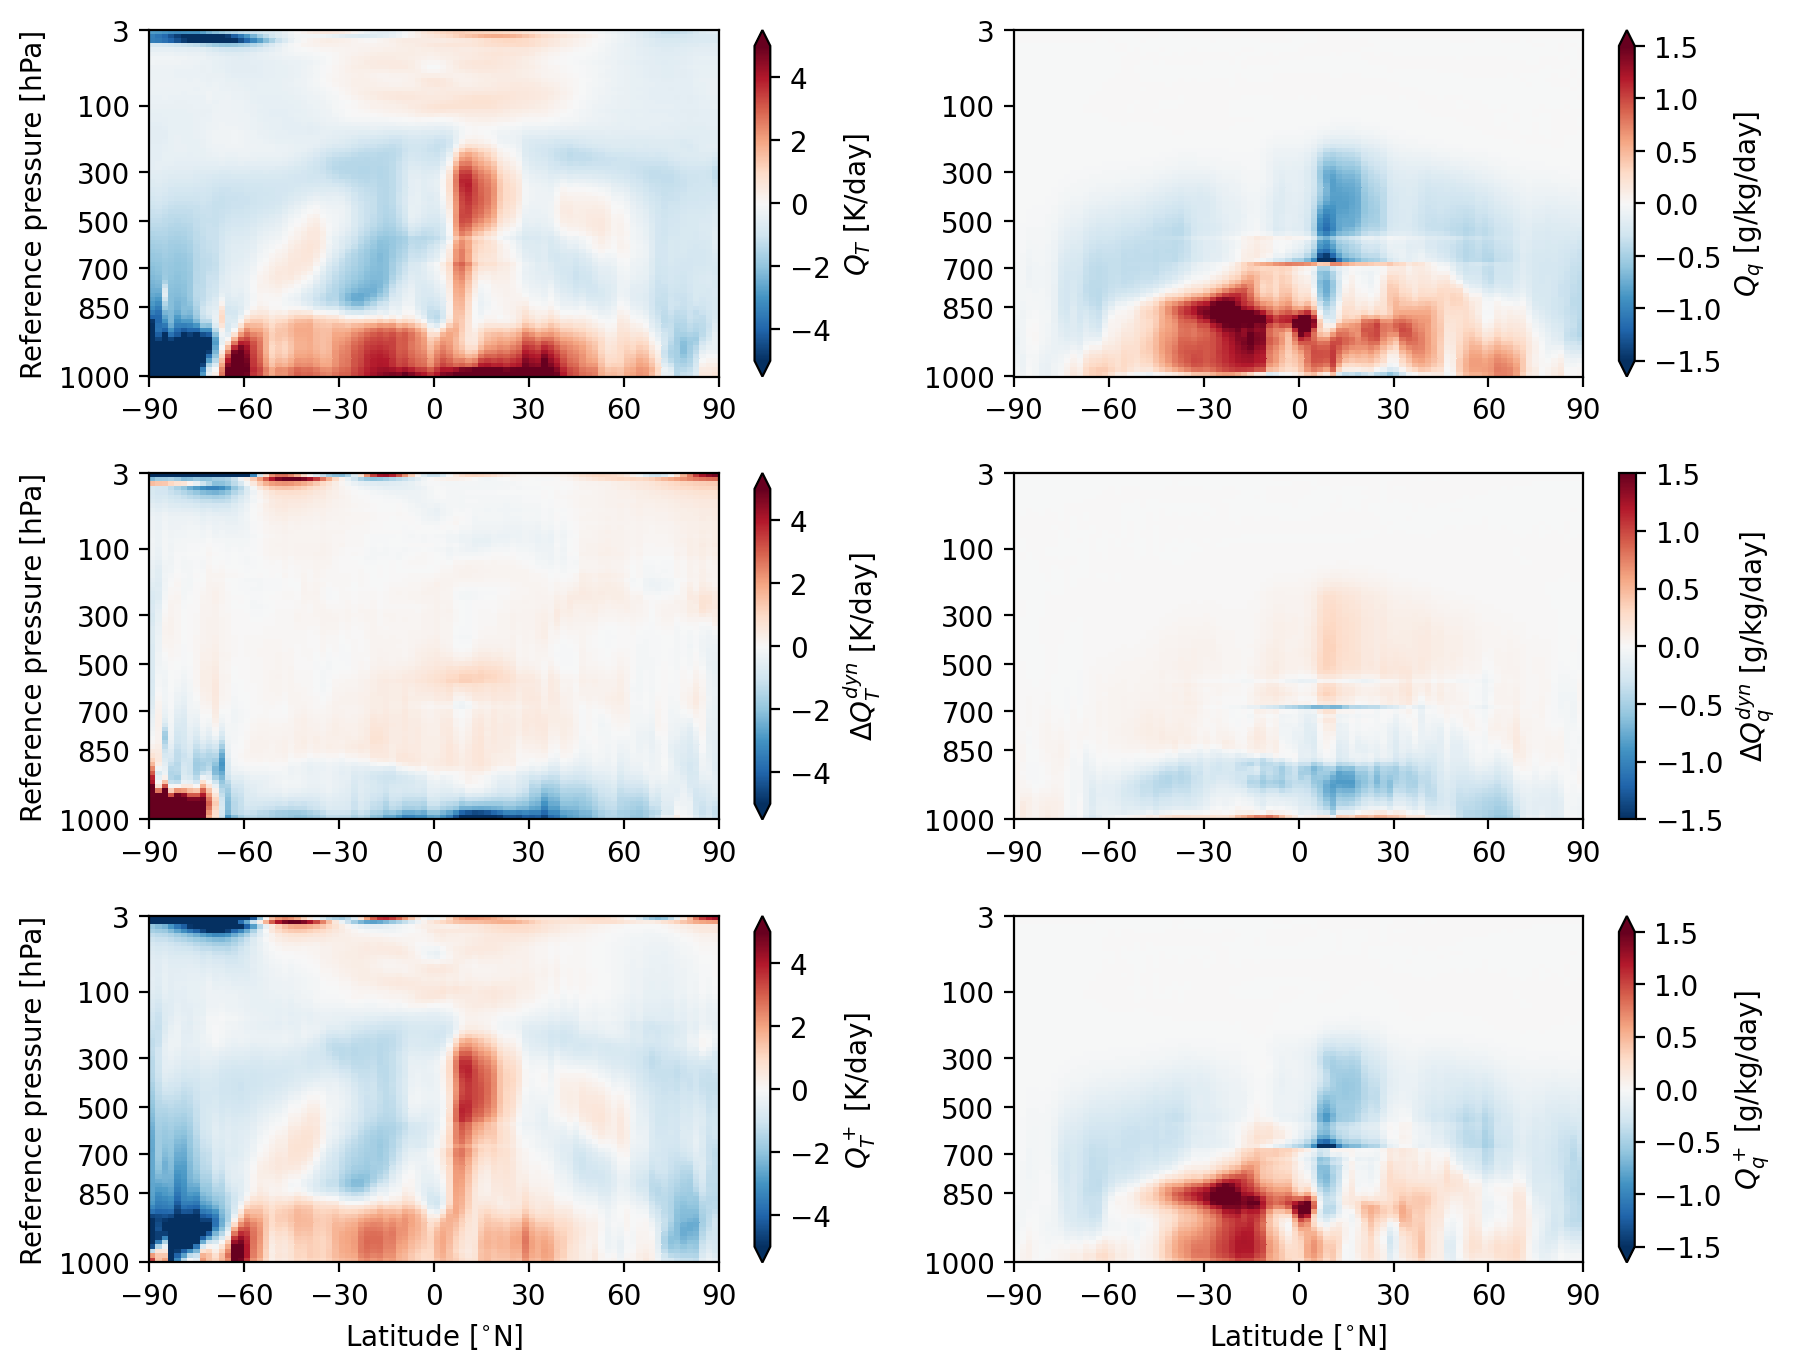

In [16]:
formats = [
    'tendency_of_{variable}_due_to_applied_physics_zonal_mean',
    '{variable}_tendency_due_to_nudging_zonal_mean',
    'tendency_of_{variable}_due_to_applied_physics_plus_nudging_zonal_mean',
]

labels = {
    'air_temperature': ['$Q_T$', '$\Delta Q_T^{dyn}$', '$Q_T^+$'],
    'specific_humidity': ['$Q_q$', '$\Delta Q_q^{dyn}$', '$Q_q^+$'],
}

fig, axes = plt.subplots(3, 2, figsize=(9, 7))
for j, format_ in enumerate(formats):
    for i, name in enumerate(['air_temperature', 'specific_humidity']):
        plotme = ds_time_mean[format_.format(variable=name)]
        plotme.attrs['long_name'] = labels[name][j]
        plotme.plot(ax=axes[j, i], y='z', yincrease=False, **KWARGS_COMBINED[name])
        axes[j, i].set_xticks(range(-90, 91, 30))
        axes[j, i].set_yticks(tick_indices)
        axes[j, i].set_yticklabels(tick_labels)
        if i == 0:
            axes[j, i].set_ylabel('Reference pressure [hPa]')
        if i == 1:
            axes[j, i].set_ylabel('')
        
        if j<2:
            axes[j, i].set_xlabel('')
        else:
            axes[j, i].set_xlabel('Latitude [$^{\circ}$N]')
            
fig.tight_layout()

### Plot vertical profile of tendencies in tropical ascent region

In [17]:
variables = [v for v in ds_time_mean if 'zonal_mean' in v]
profiles = ds_time_mean[variables].where(ds_time_mean.latitude>5).where(ds_time_mean.latitude<20).mean('latitude')

Text(-1.3, 6.5, 'b)')

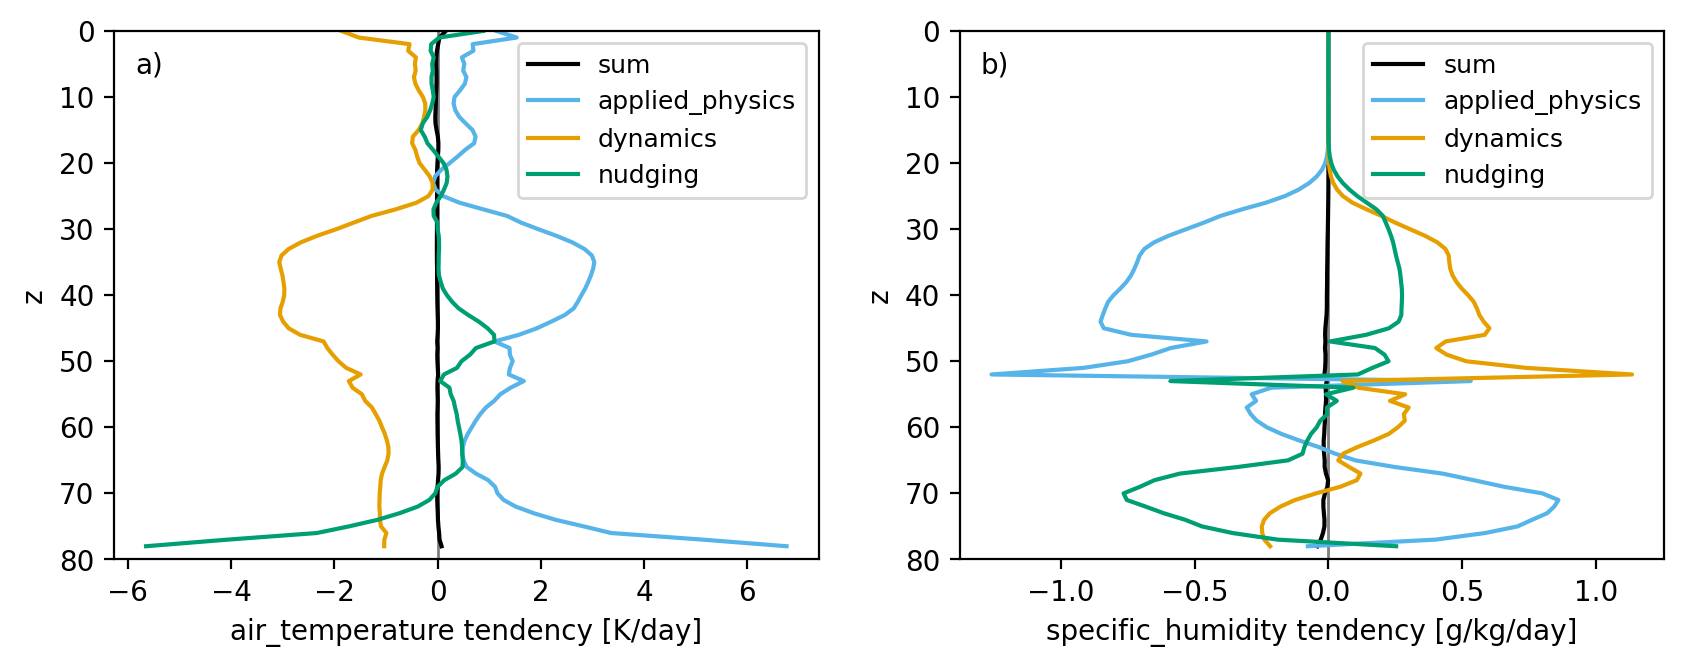

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for i, variable in enumerate(['air_temperature', 'specific_humidity']):
    tendencies = [f'tendency_of_{variable}_due_to_applied_physics_zonal_mean', f'tendency_of_{variable}_due_to_dynamics_zonal_mean', f'{variable}_tendency_due_to_nudging_zonal_mean']
    sum_ = sum([profiles[t] for t in tendencies])
    sum_.plot(ax=axes[i], y='z', yincrease=False, label='sum', color='k')
    for tendency in tendencies:
        profiles[tendency].plot(ax=axes[i], y='z', yincrease=False, label=tendency.split('due_to_')[-1][:-11])
    units = profiles[tendency].units
    axes[i].set_xlabel(f'{variable} tendency [{units}]')
    axes[i].legend(fontsize=9)
    axes[i].vlines([0], 0, 80, color='grey', linewidth=1)
    axes[i].set_ylim([80, 0])
axes[0].text(-5.85, 6.5, 'a)')
axes[1].text(-1.3, 6.5, 'b)')

#### now without dynamics or sum

Text(0, 0.5, '')

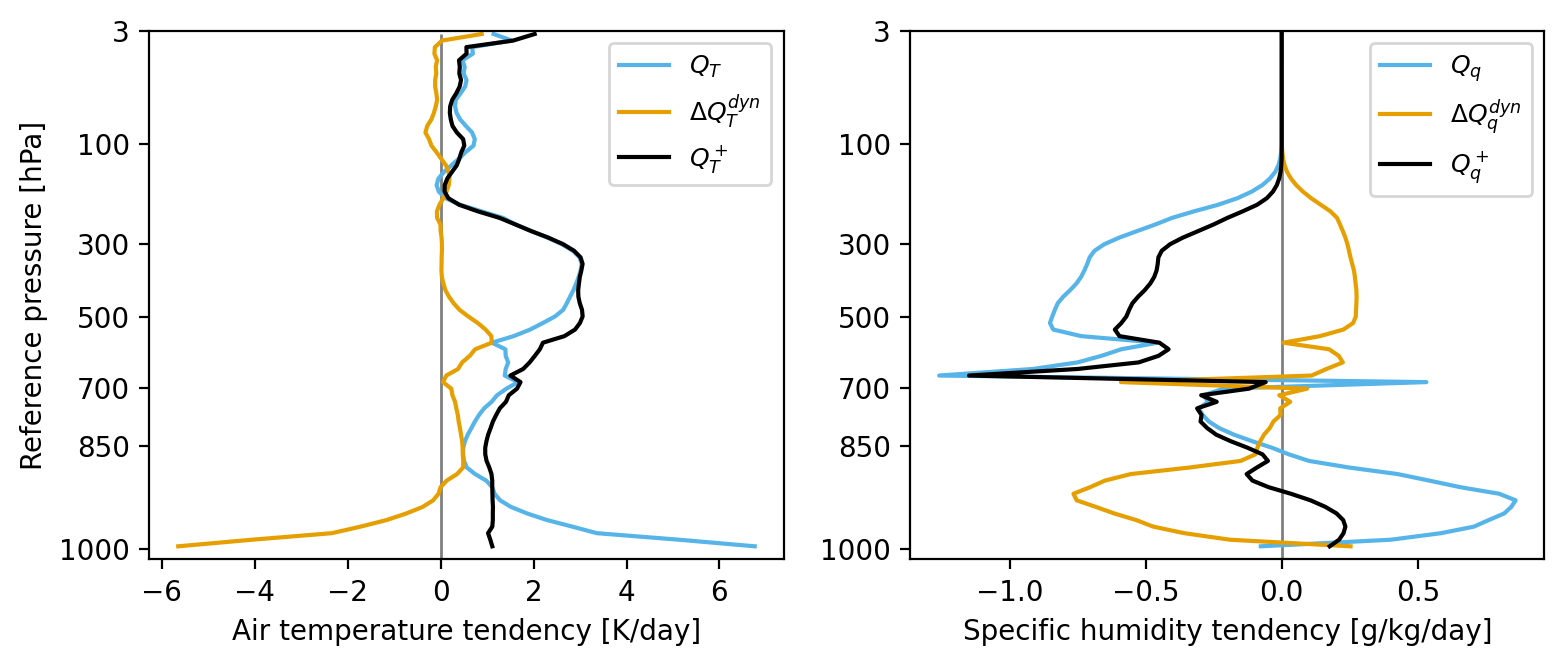

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
for i, variable in enumerate(['air_temperature', 'specific_humidity']):
    tendencies = [f'tendency_of_{variable}_due_to_applied_physics_zonal_mean', f'{variable}_tendency_due_to_nudging_zonal_mean', f'tendency_of_{variable}_due_to_applied_physics_plus_nudging_zonal_mean']
    #sum_ = sum([profiles[t] for t in tendencies])
    #sum_.plot(ax=axes[i], y='z', yincrease=False, label='sum', color='k')
    for j, tendency in enumerate(tendencies):
        kwargs = {'color': 'k'} if j == 2 else {}
        profiles[tendency].plot(ax=axes[i], y='z', yincrease=False, label=labels[variable][j], **kwargs)
    units = profiles[tendency].units
    axes[i].set_xlabel(f'{variable} tendency [{units}]')
    axes[i].legend(fontsize=9)
    axes[i].vlines([0], 0, 80, color='grey', linewidth=1)
    axes[i].set_ylim([80, 0])
    axes[i].set_yticks(tick_indices)
    axes[i].set_yticklabels(tick_labels)
axes[0].set_xlabel('Air temperature tendency [K/day]')
axes[1].set_xlabel('Specific humidity tendency [g/kg/day]')
axes[0].set_ylabel('Reference pressure [hPa]')
axes[0].set_ylabel('Reference pressure [hPa]')
axes[1].set_ylabel('')